# **Entrega 2- Ciencia de datos aplicada**
## **Política pública para la reducción de accidentes viales en Bogotá**

### GSD+ & SDM Bogotá​

### **Integrantes**
*   Yachay Tolosa Bello – 202315750
*   Kevin Infante Hernández – 201117324​
*   John Vicente Moreno Triviño – 202210162

## 0. Importación de paquetes

In [28]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from holidays import country_holidays
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

# Configuración de pandas para expandir el número de filas y columnas por defecto a mostrar
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Cambiar el formato en el que se muestran los valores float
pd.set_option("display.float_format", lambda x: "%.5f" % x)

from pycaret.classification import ClassificationExperiment, setup
from pycaret.classification import ClassificationExperiment

## 1. Modelo base

### 1. Entendimiento de datos

Se procede con el cargue de información

In [2]:
accidentes_df = pd.read_csv("./data/dataset_preparado.csv.gz")

In [3]:
accidentes_df.sample(5)

,X,Y,FORMULARIO,FECHA_OCURRENCIA_ACC,HORA_OCURRENCIA_ACC,ANO_OCURRENCIA_ACC,MES_OCURRENCIA_ACC,DIA_OCURRENCIA_ACC,DIRECCION,GRAVEDAD,CLASE_ACC,LOCALIDAD,NOMBRE_causa,TIPO_CAUSA_causa,GEOMETRICA_A_via,GEOMETRICA_B_via,GEOMETRICA_C_via,UTILIZACION_via,CALZADAS_via,CARRILES_via,MATERIAL_via,ESTADO_via,CONDICIONES_via,ILUMINACION_A_via,AGENTE_TRANSITO_via,SEMAFORO_via,CLASE_vehiculo,SERVICIO_vehiculo,col,row,cuadrante
219383,-74.11969,4.52647,A000201123,2015/05/19 00:00:00+00,20:00-21:00,2015,MAYO,MARTES,CL 68B-KR 14A S 02,SOLO DANOS,CHOQUE,USME,REVERSO IMPRUDENTE,CONDUCTOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUTOMOVIL,PUBLICO,3,2,8
607979,-74.07257,4.62189,A001387198,2021/12/13 00:00:00+00,13:00-14:00,2021,DICIEMBRE,LUNES,KR 17 - CL 33 02,CON HERIDOS,CHOQUE,TEUSAQUILLO,NO RESPETAR PRELACIÓN,CONDUCTOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUS,PUBLICO,4,4,19
234834,-74.05965,4.66441,A000649644,2017/07/20 00:00:00+00,07:00-08:00,2017,JULIO,JUEVES,KR 77-CL 16A 2,SOLO DANOS,CHOQUE,CHAPINERO,DESOBEDECER SEÑALES,CONDUCTOR,RECTA,PLANO,CON ANDEN,UN SENTIDO,UNA,UNO,ASFALTO,BUENO,SECA,CON,NO,OPERANDO,AUTOMOVIL,PUBLICO,4,5,24
358874,-74.13073,4.72256,A000868920,2018/10/26 00:00:00+00,10:00-11:00,2018,OCTUBRE,VIERNES,DG 77B-KR 119A 73,SOLO DANOS,CHOQUE,ENGATIVA,NaN,NaN,RECTA,PLANO,CON ANDEN,DOBLE SENTIDO,DOS,TRES O MAS,ASFALTO,BUENO,SECA,CON,SI,OPERANDO,BUS,PUBLICO,3,7,33
443846,-74.10892,4.59701,A000864943,2018/07/21 00:00:00+00,01:00-02:00,2018,JULIO,SABADO,AK 30-CL 15 S 2,SOLO DANOS,CHOQUE,ANTONIO NARINO,NO MANTENER DISTANCIA DE SEGURIDAD,CONDUCTOR,RECTA,PLANO,CON BERMAS,UN SENTIDO,DOS,TRES O MAS,ASFALTO,BUENO,NO SECA,CON,NO,NO OPERANDO,"CAMION, FURGON",PARTICULAR,3,4,18


In [ ]:
accidentes_df.dtypes

X                       float64
Y                       float64
FORMULARIO               object
FECHA_OCURRENCIA_ACC     object
HORA_OCURRENCIA_ACC      object
ANO_OCURRENCIA_ACC        int64
MES_OCURRENCIA_ACC       object
DIA_OCURRENCIA_ACC       object
DIRECCION                object
GRAVEDAD                 object
CLASE_ACC                object
LOCALIDAD                object
NOMBRE_causa             object
TIPO_CAUSA_causa         object
GEOMETRICA_A_via         object
GEOMETRICA_B_via         object
GEOMETRICA_C_via         object
UTILIZACION_via          object
CALZADAS_via             object
CARRILES_via             object
MATERIAL_via             object
ESTADO_via               object
CONDICIONES_via          object
ILUMINACION_A_via        object
AGENTE_TRANSITO_via      object
SEMAFORO_via             object
CLASE_vehiculo           object
SERVICIO_vehiculo        object
dtype: object

### 2. Clasificación en cuadrantes

In [ ]:
bottomLeft = (4.45422, -74.22446)
bottomRight = (4.45422, -73.99208494428275)
topLeft = (4.833779672812246, -74.22446)
topRight = (4.833779672812246, -73.99208494428275)

cols = np.linspace(bottomLeft[1], bottomRight[1], num=13)
rows = np.linspace(bottomLeft[0], topLeft[0], num=21)
accidentes_df["col"] = np.searchsorted(cols, accidentes_df["X"])
accidentes_df["row"] = np.searchsorted(rows, accidentes_df["Y"])

Se descartan los registros que están por fuera de los limites, es decir, que fueron asignados en una posición menor al límite izquierdo y al límite inferior, ya que son posiciones fuera del área urbana de Bogotá, que es el área de interés de este trabajo

In [ ]:
accidentes_df = accidentes_df.loc[accidentes_df["col"] > 0]
accidentes_df = accidentes_df.loc[accidentes_df["row"] > 0]

In [ ]:
accidentes_df['cuadrante'] = ((accidentes_df["row"] - 1) * (len(cols) - 1)) + (accidentes_df["col"])

In [ ]:
cuadrantes = accidentes_df["cuadrante"].unique()
cuadrantes.sort()
print(cuadrantes)

[  5   6  17  18  19  28  29  30  31  32  40  41  42  43  44  52  53  54
  55  56  57  63  64  65  66  67  68  69  75  76  77  78  79  80  81  82
  83  85  86  87  88  89  90  91  92  93  94  97  98  99 100 101 102 103
 104 105 109 110 111 112 113 114 115 116 117 122 123 124 125 126 127 128
 129 130 135 136 137 138 139 140 141 142 143 144 147 148 149 150 151 152
 153 154 155 160 161 162 163 164 165 166 167 173 174 175 176 177 178 179
 185 186 187 188 189 190 191 198 199 200 201 202 203 211 212 213 214 215
 223 224 225 226 227 236 237 238 239]


### 3. Gráfica de resultados

In [8]:
mapa_bogota = geopandas.read_file("./data/bogota_cadastral.json")

Se descarta el área de Sumapaz

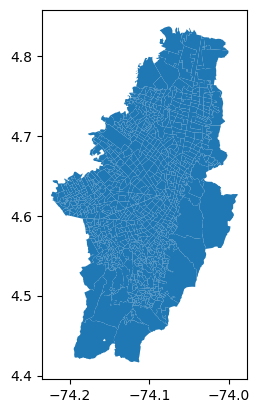

In [ ]:
mapa_bogota_no_sumapaz = mapa_bogota.cx[:, bottomLeft[0] :]
mapa_bogota_plot = mapa_bogota_no_sumapaz.plot()

In [ ]:
mapa_bogota_no_sumapaz.head()

,cartodb_id,scacodigo,scatipo,scanombre,shape_leng,shape_area,MOVEMENT_ID,DISPLAY_NAME,geometry
0,12,004575,0,LOS LAURELES,0.02774,0.00004,1,"LOS LAURELES, 004575 (1)","MULTIPOLYGON (((-74.20029 4.61725, -74.20028 4..."
1,26,006524,0,LA MAGDALENA,0.05322,0.00009,2,"LA MAGDALENA, 006524 (2)","MULTIPOLYGON (((-74.16276 4.66008, -74.16272 4..."
2,45,102502,1,EL UVAL RURAL,0.17133,0.00071,3,"EL UVAL RURAL, 102502 (3)","MULTIPOLYGON (((-74.11931 4.49017, -74.11933 4..."
3,74,005501,0,PALO BLANCO,0.01719,0.00002,4,"PALO BLANCO, 005501 (4)","MULTIPOLYGON (((-74.09353 4.68101, -74.09481 4..."
4,77,009240,0,POTRERILLO,0.01053,0.00001,5,"POTRERILLO, 009240 (5)","MULTIPOLYGON (((-74.09744 4.73531, -74.09620 4..."


Se crea un dataframe con las filas y las columnas

In [ ]:
cuadrantes_cord = []
for i in range(len(rows) - 1):
    for j in range(len(cols) - 1):
        poly = shapely.geometry.box(cols[j], rows[i], cols[j + 1], rows[i + 1])
        cuadrantes_cord.append(poly)

cuadrantes_gdf = geopandas.GeoDataFrame(
    cuadrantes_cord, columns=["geometry"], crs=mapa_bogota_no_sumapaz.crs
)

In [ ]:
cuadrantes_gdf.head(5)

,geometry
0,"POLYGON ((-74.20510 4.45422, -74.20510 4.47320..."
1,"POLYGON ((-74.18573 4.45422, -74.18573 4.47320..."
2,"POLYGON ((-74.16637 4.45422, -74.16637 4.47320..."
3,"POLYGON ((-74.14700 4.45422, -74.14700 4.47320..."
4,"POLYGON ((-74.12764 4.45422, -74.12764 4.47320..."


Se grafican los cuadrantes sobre el mapa de Bogotá. El área por fuera de los cuadrantes está por fuera del área urbana de la ciudad

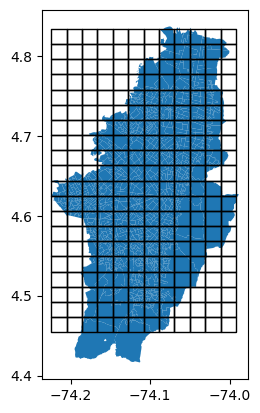

In [ ]:
cuadrantes_gdf = cuadrantes_gdf.to_crs(mapa_bogota_no_sumapaz.crs)
fig, ax = plt.subplots()
mapa_bogota_no_sumapaz.plot(ax=ax)
cuadrantes_gdf.plot(ax=ax, fc="none", ec="black")
plt.show()

Se agrega una columna con el identificador del cuadrante en el geodataframe

In [ ]:
cuadrantes_gdf["id_cuadrante"] = cuadrantes_gdf.index + 1

### 4. Generando un conjunto de datos con los positivos y negativos

Dado que en este set de datos solamente se tienen datos de accidentes y se busca abordar este problema como uno de clasificación, se deben generar las franjas de tiempo y cuadrantes en los cuales no hay accidentes.

In [ ]:
fecha_hora = pd.to_datetime(
    accidentes_df["FECHA_OCURRENCIA_ACC"].str[:11]
    + accidentes_df["HORA_OCURRENCIA_ACC"].str[:2]
)

Creamos un dataframe con una fila por cada combinación de fecha, hora y cuadrante:

In [ ]:
fechas = pd.DataFrame(
    pd.date_range(
        fecha_hora.min(),
        fecha_hora.max(),
        freq="1h",
    ),
    columns=["FECHA"],
)

cuadrantes = pd.DataFrame(
    range(1, accidentes_df["cuadrante"].max()),
    columns=["CUADRANTE"],
)


df_base = fechas.merge(cuadrantes, how="cross")

df_base.head()

,FECHA,CUADRANTE
0,2015-01-01 01:00:00,1
1,2015-01-01 01:00:00,2
2,2015-01-01 01:00:00,3
3,2015-01-01 01:00:00,4
4,2015-01-01 01:00:00,5


Agregamos la información de los accidentes

In [ ]:
df_base = df_base.join(
    accidentes_df.groupby([fecha_hora, "cuadrante"]).agg(
        numero_accidentes=("X", "size"),
    ),
    on=["FECHA", "CUADRANTE"],
).fillna(0)

Agregamos información de los cuadrantes (coordenadas promedio)

In [ ]:
df_base = df_base.join(
    accidentes_df.groupby("cuadrante").agg(X=("X", "mean"), Y=("Y", "mean")),
    on="CUADRANTE",
)

df_base.head()

,FECHA,CUADRANTE,numero_accidentes,X,Y
0,2015-01-01 01:00:00,1,0.00000,NaN,NaN
1,2015-01-01 01:00:00,2,0.00000,NaN,NaN
2,2015-01-01 01:00:00,3,0.00000,NaN,NaN
3,2015-01-01 01:00:00,4,0.00000,NaN,NaN
4,2015-01-01 01:00:00,5,0.00000,-74.12934,4.46723


Eliminamos los cuadrantes donde nunca han habido accidentes:

In [ ]:
df_base = df_base.dropna(subset=["X", "Y"]).copy()

Enriquecemos el dataset con festivos, semana, mes, día de la semana e información de si era un festivo

In [ ]:
df_base["hora"] = df_base.FECHA.dt.hour
df_base["semana_del_año"] = df_base.FECHA.dt.isocalendar().week
df_base["dia_de_la_semana"] = df_base.FECHA.dt.weekday

Marcamos los festivos

In [ ]:
colombian_holidays = country_holidays("CO")

holidays = pd.DataFrame(
    index=pd.date_range(fecha_hora.min(), fecha_hora.max(), freq="d", normalize=True)
)

holidays["festivo"] = np.where(
    holidays.index.map(lambda x: x in colombian_holidays), 1, 0
)

df_base["fecha_truncada"] = df_base["FECHA"].dt.floor("d")

df_base = df_base.join(holidays, on="fecha_truncada").drop(columns="fecha_truncada")

Se añaden algunos resagos de la variable número de accidentes: del día anterior, de la semana anterior:

In [ ]:
df_base = df_base.join(
    df_base.groupby(["CUADRANTE"]).apply(
        lambda x: x.set_index("FECHA").shift(1, freq="d")
    )["numero_accidentes"],
    on=["CUADRANTE", "FECHA"],
    rsuffix="_1_dia_atras",
).join(
    df_base.groupby(["CUADRANTE"]).apply(
        lambda x: x.set_index("FECHA").shift(7, freq="d")
    )["numero_accidentes"],
    on=["CUADRANTE", "FECHA"],
    rsuffix="_7_dias_atras",
)

# Eliminamos las primeras filas que no tienen resago
df_base = df_base.dropna(subset=["numero_accidentes_7_dias_atras"])

In [ ]:
df_base["accidente"] = np.where(df_base["numero_accidentes"] > 0, 1, 0)

<Axes: >

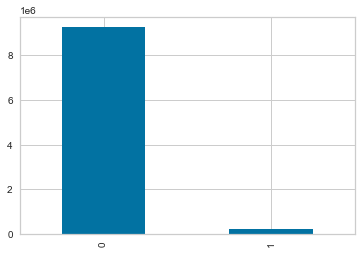

In [ ]:
df_base["accidente"].value_counts().plot.bar()

Se nota un alto desbalanceo de clases, el cual se manejará más adelante cuando se halle el mejor modelo. Por lo pronto, en esta sección se continuará con la construcción del modelo base.

### 5. Modelo

El algoritmo seleccionado para el modelo base es regresión logística. Primero, se separa la variable objetivo de las demás

In [ ]:
y = df_base["accidente"]
X = df_base[
    [
        "CUADRANTE",
        "X",
        "Y",
        "hora",
        "semana_del_año",
        "dia_de_la_semana",
        "festivo",
        "numero_accidentes_1_dia_atras",
        "numero_accidentes_7_dias_atras",
    ]
]

Dividimos los datos entre entrenamiento y prueba
seleccionando para prueba los días que corresponden al último 30% de los datos

In [ ]:
fecha_corte_test_train = df_base["FECHA"] <= df_base["FECHA"].quantile(0.7)

X_train = X[fecha_corte_test_train]
X_test = X[~fecha_corte_test_train]

y_train = y[fecha_corte_test_train]
y_test = y[~fecha_corte_test_train]

Dado que tenemos algunas variables que son cíclicas aplicamos creamos transformadores para aplicar seno y coseno:

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

Creamos el preprocesamiento de los datos

In [ ]:
preproc = make_column_transformer(
    (sin_transformer(24), ["hora"]),
    (cos_transformer(24), ["hora"]),
    (sin_transformer(7), ["dia_de_la_semana"]),
    (cos_transformer(7), ["dia_de_la_semana"]),
    (sin_transformer(53), ["semana_del_año"]),
    (cos_transformer(53), ["semana_del_año"]),
    (
        StandardScaler(),
        [
            "numero_accidentes_1_dia_atras",
            "numero_accidentes_7_dias_atras",
            "X",
            "Y",
        ],
    ),
)

Modelo con algoritmo de regresión logística, en el cual se especifica el parámetro `class_weight` como "balanced" para que el algoritmo le asigne un peso mayor a la clase minoritaria

In [ ]:
modelo = make_pipeline(preproc, LogisticRegression(class_weight="balanced"))

In [ ]:
modelo.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x00000201B1685DC0>),
                                                  ['hora']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x00000201C0F0C8B0>),
                                                  ['hora']),
                                                 ('functiontransformer-3',
                                                  Functi...
                                                  FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x00000201C0F0CA60>),
                                                  ['semana_del_año']),
                                                 ('functiontransformer-6',
                                                  FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x00000201C0F0CAF0>),
                                                  ['semana_del_año']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['numero_accidentes_1_dia_atras',
                                                   'numero_accidentes_7_dias_atras',
                                                   'X', 'Y'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

### 6. Evaluación

In [ ]:
y_pred = modelo.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.56      0.98      0.72   1587102
           1       0.61      0.03      0.06   1256378

    accuracy                           0.56   2843480
   macro avg       0.59      0.51      0.39   2843480
weighted avg       0.58      0.56      0.42   2843480



Se ve que el f1-score no supera ni siquiera el puntaje de un clasificador aleatorio, lo cual se debe en buena parte al alto desbalanceo de clases. Por ende, es necesario mejorar el balanceo de clases, para lo cual en la sección siguiente se ampliará el tamaño del cuadrante y se ampliará la franja horaria.

### 7. Hallar los modelos con f1-score más alto usando classification experiment

Se crea la instancia de classification experiment

In [ ]:
s = ClassificationExperiment()
s.setup(
    X_train.assign(accidente=y_train),
    test_data=X_test.assign(accidente=y_test),
    target="accidente",
    session_id=123,
    use_gpu=False,
    fix_imbalance=True,
    fold_strategy="timeseries",
    data_split_shuffle=False,
    fold_shuffle=False,
)

,Description,Value
0,Session id,123
1,Target,accidente
2,Target type,Binary
3,Original data shape,"(9478490, 10)"
4,Transformed data shape,"(15783382, 10)"
5,Transformed train set shape,"(12939902, 10)"
6,Transformed test set shape,"(2843480, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


Se comparan varios modelos usando grid search

In [ ]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9749,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,5.4360
catboost,CatBoost Classifier,0.9746,0.8109,0.0018,0.0860,0.0034,0.0026,0.0079,279.6750
lightgbm,Light Gradient Boosting Machine,0.9657,0.8126,0.0465,0.1051,0.0391,0.0311,0.0381,18.4290
dt,Decision Tree Classifier,0.9612,0.5415,0.0456,0.0741,0.0527,0.0352,0.0375,25.6480
xgboost,Extreme Gradient Boosting,0.9528,0.8083,0.1111,0.1206,0.0800,0.0634,0.0743,17.5850
knn,K Neighbors Classifier,0.8592,0.6403,0.2980,0.0600,0.0965,0.0581,0.0811,37.2370
gbc,Gradient Boosting Classifier,0.7990,0.7982,0.6020,0.0739,0.1310,0.0906,0.1569,309.8640
ada,Ada Boost Classifier,0.6990,0.7703,0.7091,0.0573,0.1058,0.0624,0.1374,86.5200
rf,Random Forest Classifier,0.5760,0.3264,0.0266,0.0447,0.0324,0.0212,0.0223,266.7800
nb,Naive Bayes,0.5636,0.7402,0.7938,0.0441,0.0835,0.0379,0.1103,5.5740


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Se ve que el modelo con f1-score más alto es "Gradient Boost Classifier" (XGBoost), seguido de random forest y regresión logística. En la siguiente sección se crearán modelos usando estos tres algoritmos y se mejorará el balanceo de clases, de modo que se obtenga una mejora con respecto al modelo base.

## 2. Búsqueda de mejor modelo

### 1. Re-clasificación en cuadrantes

Se amplia el tamaño de los cuadrantes al doble de lo establecido previamente, es decir, quedan de aproximadamente 4 kilómetros

In [4]:
ncols = 6
nrows = 10

bottomLeft = (4.45422, -74.22446)
bottomRight = (4.45422, -73.99208494428275)
topLeft = (4.833779672812246, -74.22446)
topRight = (4.833779672812246, -73.99208494428275)

cols = np.linspace(bottomLeft[1], bottomRight[1], num=ncols)
rows = np.linspace(bottomLeft[0], topLeft[0], num=nrows)
accidentes_df["col"] = np.searchsorted(cols, accidentes_df["X"])
accidentes_df["row"] = np.searchsorted(rows, accidentes_df["Y"])

Se descartan los registros que están por fuera de los limites, es decir, que fueron asignados en una posición menor al límite izquierdo y al límite inferior, ya que son posiciones fuera del área urbana de Bogotá, que es el área de interés de este trabajo

In [5]:
accidentes_df = accidentes_df.loc[accidentes_df["col"] > 0]
accidentes_df = accidentes_df.loc[accidentes_df["row"] > 0]
accidentes_df['cuadrante'] = ((accidentes_df["row"] - 1) * (len(cols) - 1)) + (accidentes_df["col"])

In [6]:
cuadrantes = accidentes_df["cuadrante"].unique()
cuadrantes.sort()
cuadrantes

array([ 2,  3,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 38, 39, 40, 43, 44, 45])

### 2. Nueva gráfica de resultados

Se descarta el área de Sumapaz

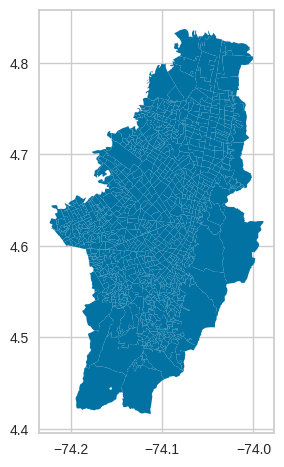

In [9]:
mapa_bogota_no_sumapaz = mapa_bogota.cx[:, bottomLeft[0] :]
mapa_bogota_plot = mapa_bogota_no_sumapaz.plot()

Se crea un dataframe con las filas y las columnas

In [10]:
cuadrantes_cord = []
for i in range(len(rows) - 1):
    for j in range(len(cols) - 1):
        poly = shapely.geometry.box(cols[j], rows[i], cols[j + 1], rows[i + 1])
        cuadrantes_cord.append(poly)

cuadrantes_gdf = geopandas.GeoDataFrame(
    cuadrantes_cord, columns=["geometry"], crs=mapa_bogota_no_sumapaz.crs
)

Se grafican los nuevos cuadrantes sobre el mapa de Bogotá. El área por fuera de los cuadrantes está por fuera del área urbana de la ciudad

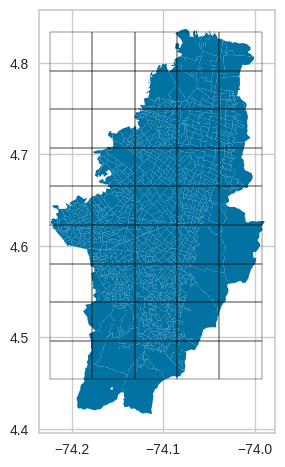

In [11]:
cuadrantes_gdf = cuadrantes_gdf.to_crs(mapa_bogota_no_sumapaz.crs)
fig, ax = plt.subplots()
mapa_bogota_no_sumapaz.plot(ax=ax)
cuadrantes_gdf.plot(ax=ax, fc="none", ec="black")
plt.show()

Se ve que ahora los cuadrantes son más grandes

Se agrega una columna con el identificador del cuadrante en el geodataframe

In [12]:
cuadrantes_gdf["id_cuadrante"] = cuadrantes_gdf.index + 1

### 3. Generando un conjunto de datos con los positivos y negativos

In [13]:
fecha_hora = pd.to_datetime(
    accidentes_df["FECHA_OCURRENCIA_ACC"].str[:11]
    + accidentes_df["HORA_OCURRENCIA_ACC"].str[:2]
)

Creamos un dataframe con una fila por cada combinación de fecha, hora y cuadrante:

In [14]:
fechas = pd.DataFrame(
    pd.date_range(
        fecha_hora.min(),
        fecha_hora.max(),
        freq="1h",
    ),
    columns=["fecha"],
)

cuadrantes = pd.DataFrame(
    range(1, accidentes_df["cuadrante"].max()),
    columns=["cuadrante"],
)

df_base = fechas.merge(cuadrantes, how="cross")

Agregamos la información de los accidentes

In [15]:
df_base = df_base.join(
    accidentes_df.groupby([fecha_hora, "cuadrante"]).size().rename("numero_de_accidentes"),
    on=["fecha", "cuadrante"]
)

df_base["numero_de_accidentes"] = df_base["numero_de_accidentes"].fillna(0)

In [16]:
df_base.head()

,fecha,cuadrante,numero_de_accidentes
0,2015-01-01 01:00:00,1,0.00000
1,2015-01-01 01:00:00,2,0.00000
2,2015-01-01 01:00:00,3,0.00000
3,2015-01-01 01:00:00,4,0.00000
4,2015-01-01 01:00:00,5,0.00000


Remuestreamos para tener grupos de 4 horas

In [17]:
df_base = df_base.groupby(["cuadrante", pd.Grouper(key="fecha", freq="4h")], as_index=True).sum().reset_index()
df_base.head()

,cuadrante,fecha,numero_de_accidentes
0,1,2015-01-01 00:00:00,0.00000
1,1,2015-01-01 04:00:00,0.00000
2,1,2015-01-01 08:00:00,0.00000
3,1,2015-01-01 12:00:00,0.00000
4,1,2015-01-01 16:00:00,0.00000


Agregamos información de los cuadrantes (coordenadas promedio)

In [18]:
df_base = df_base.join(
    accidentes_df.groupby("cuadrante").agg(X=("X", "mean"), Y=("Y", "mean")),
    on="cuadrante",
)

# Eliminamos los cuadrantes donde nunca han habido accidentes:
df_base = df_base.dropna(subset=["X", "Y"]).copy()

df_base.head()

,cuadrante,fecha,numero_de_accidentes,X,Y
17726,2,2015-01-01 00:00:00,0.00000,-74.13568,4.46734
17727,2,2015-01-01 04:00:00,0.00000,-74.13568,4.46734
17728,2,2015-01-01 08:00:00,0.00000,-74.13568,4.46734
17729,2,2015-01-01 12:00:00,0.00000,-74.13568,4.46734
17730,2,2015-01-01 16:00:00,0.00000,-74.13568,4.46734


Enriquecemos el dataset con festivos, semana, mes, día de la semana e información de si era un festivo

In [19]:
df_base["hora"] = df_base.fecha.dt.hour
df_base["semana_del_año"] = df_base.fecha.dt.isocalendar().week
df_base["dia_de_la_semana"] = df_base.fecha.dt.weekday
df_base["mes"] = df_base.fecha.dt.month

Marcamos los festivos

In [20]:
colombian_holidays = country_holidays("CO")

holidays = pd.DataFrame(
    index=pd.date_range(fecha_hora.min(), fecha_hora.max(), freq="d", normalize=True)
)

holidays["festivo"] = np.where(
    holidays.index.map(lambda x: x in colombian_holidays), 1, 0
)

df_base["fecha_truncada"] = df_base["fecha"].dt.floor("d")

df_base = df_base.join(holidays, on="fecha_truncada").drop(columns="fecha_truncada")

In [21]:
df_base.head()

,cuadrante,fecha,numero_de_accidentes,X,Y,hora,semana_del_año,dia_de_la_semana,mes,festivo
17726,2,2015-01-01 00:00:00,0.00000,-74.13568,4.46734,0,1,3,1,1
17727,2,2015-01-01 04:00:00,0.00000,-74.13568,4.46734,4,1,3,1,1
17728,2,2015-01-01 08:00:00,0.00000,-74.13568,4.46734,8,1,3,1,1
17729,2,2015-01-01 12:00:00,0.00000,-74.13568,4.46734,12,1,3,1,1
17730,2,2015-01-01 16:00:00,0.00000,-74.13568,4.46734,16,1,3,1,1


Se añaden un rezago de la variable número de accidentes: de 15 días antes a la misma hora

In [22]:
dias = 15
accidentes_15_dias_misma_hora = sum(
    df_base.groupby("cuadrante").apply(lambda x: x.set_index("fecha").shift(d, freq="d"))["numero_de_accidentes"]
    for d in range(dias)
).rename("accidentes_15_dias_misma_hora")

df_base = df_base.join(accidentes_15_dias_misma_hora, on=["cuadrante", "fecha"])

df_base.head()

,cuadrante,fecha,numero_de_accidentes,X,Y,hora,semana_del_año,dia_de_la_semana,mes,festivo,accidentes_15_dias_misma_hora
17726,2,2015-01-01 00:00:00,0.00000,-74.13568,4.46734,0,1,3,1,1,NaN
17727,2,2015-01-01 04:00:00,0.00000,-74.13568,4.46734,4,1,3,1,1,NaN
17728,2,2015-01-01 08:00:00,0.00000,-74.13568,4.46734,8,1,3,1,1,NaN
17729,2,2015-01-01 12:00:00,0.00000,-74.13568,4.46734,12,1,3,1,1,NaN
17730,2,2015-01-01 16:00:00,0.00000,-74.13568,4.46734,16,1,3,1,1,NaN


In [23]:
# Eliminamos las primeras filas que no tienen resago
df_base = df_base.dropna(subset=["accidentes_15_dias_misma_hora"])

#### 3.1. Nuevo balance de clases

In [24]:
df_base["accidente"] = np.where(df_base["numero_de_accidentes"] > 0, 1, 0)

<Axes: >

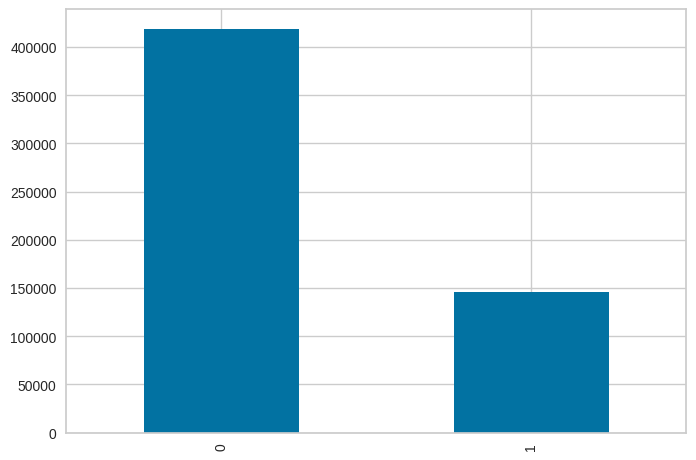

In [25]:
df_base["accidente"].value_counts().plot.bar()

Se nota una amplia mejora en el balanceo de clases con respecto al modelo base

Se eliminan los cuadrantes en los que no hay accidentes y se grafica, con lo cual se ve que estos se ajustan más al área geográfica de la ciudad

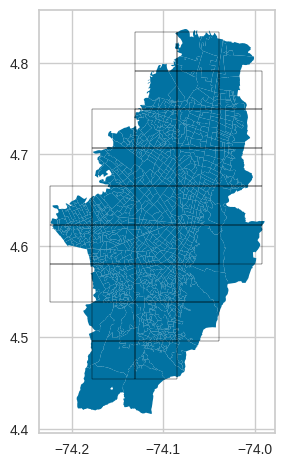

In [26]:
fig, ax = plt.subplots()
mapa_bogota_no_sumapaz.plot(ax=ax)
cuadrantes_gdf[cuadrantes_gdf['id_cuadrante'].isin(df_base['cuadrante'].unique())].plot(ax=ax, fc="none", ec="black")
plt.show()

### 4. Exploración

Se muestran métricas sobre el dataset construido para entender mejor la distribución de los datos

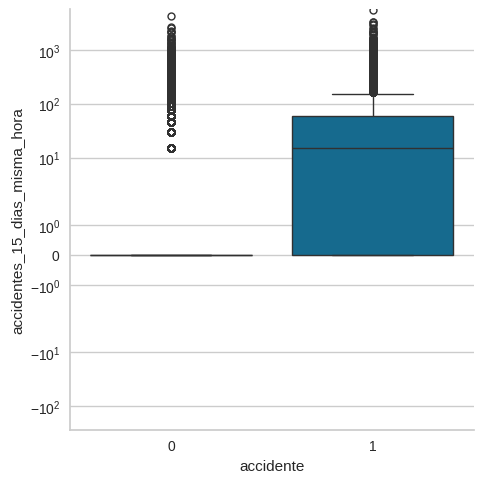

In [29]:
g = sns.catplot(df_base, x="accidente", y="accidentes_15_dias_misma_hora", kind="box" )

g.ax.set_yscale("symlog")

<Axes: title={'center': 'Porcentaje de parches con accidentes según la hora'}, xlabel='hora'>

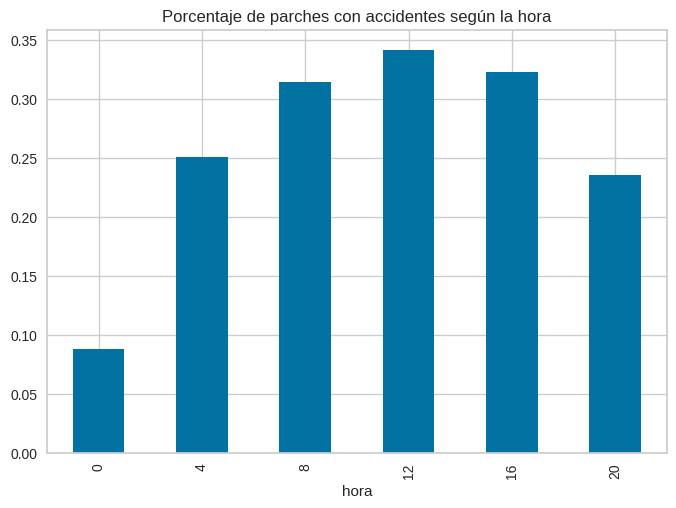

In [30]:
df_base.groupby("hora")["accidente"].mean().plot.bar(title="Porcentaje de parches con accidentes según la hora")

<Axes: title={'center': 'Porcentaje de parches con accidentes según e día de la semana'}, xlabel='dia_de_la_semana'>

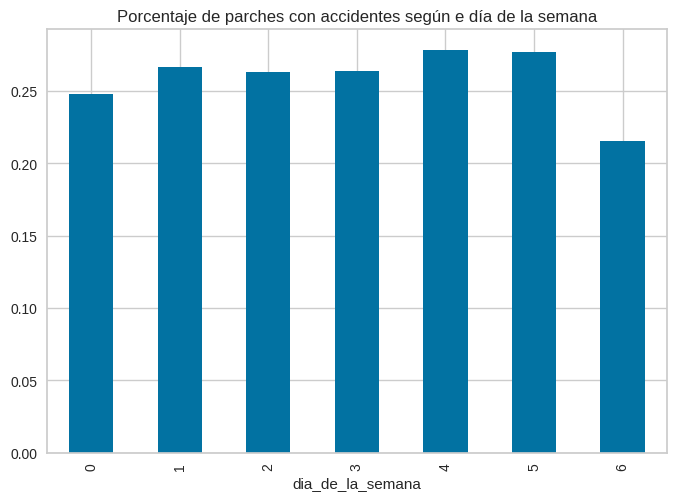

In [31]:
df_base.groupby("dia_de_la_semana")["accidente"].mean().plot.bar(title="Porcentaje de parches con accidentes según e día de la semana")

<Axes: title={'center': 'Porcentaje de parches con accidentes según si el día es festivo'}, xlabel='festivo'>

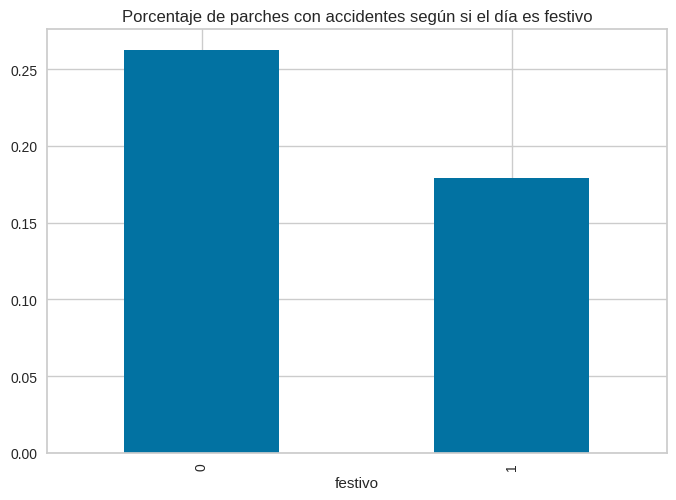

In [32]:
df_base.groupby("festivo")["accidente"].mean().plot.bar(title="Porcentaje de parches con accidentes según si el día es festivo")

### 5. Modelo

Se separa la variable objetivo de las demás

In [33]:
df_base = df_base.sort_values(["fecha", "cuadrante"])

y = df_base["accidente"]
X = df_base[
    [
        # "cuadrante",
        "X",
        "Y",
        "hora",
        "semana_del_año",
        "dia_de_la_semana",
        "festivo",
        "accidentes_15_dias_misma_hora",
        "mes",
    ]
]

Dividimos los datos entre entrenamiento y prueba
seleccionando para prueba los días que corresponden al último 30% de los datos

In [34]:
fecha_corte_test_train = df_base["fecha"] <= df_base["fecha"].quantile(0.7)

X_train = X[fecha_corte_test_train]
X_test = X[~fecha_corte_test_train]

y_train = y[fecha_corte_test_train]
y_test = y[~fecha_corte_test_train]

Dado que tenemos algunas variables que son cíclicas creamos transformadores para aplicar seno y coseno:

In [35]:
def sin_transform(x, period):
     return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
     return np.cos(x / period * 2 * np.pi)

def sin_transformer(period):
    return FunctionTransformer(sin_transform, feature_names_out="one-to-one", kw_args=dict(period=period))


def cos_transformer(period):
    return FunctionTransformer(cos_transform, feature_names_out="one-to-one", kw_args=dict(period=period))


Creamos el preprocesamiento de los datos

In [36]:
preproc = make_column_transformer(
    (sin_transformer(24), ["hora"]),
    (cos_transformer(24), ["hora"]),
    (sin_transformer(7), ["dia_de_la_semana"]),
    (cos_transformer(7), ["dia_de_la_semana"]),
    (sin_transformer(53), ["semana_del_año"]),
    (cos_transformer(53), ["semana_del_año"]),
    (sin_transformer(12), ["mes"]),
    (cos_transformer(12), ["mes"]),
    (StandardScaler(), ["accidentes_15_dias_misma_hora", "X", "Y"]),
    ("passthrough", ["festivo"])
)

#### 5.1. Regresión logística

In [37]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

lr_model = Pipeline([
   ("preprocesamiento", preproc), 
   ("remuestreo", SMOTE()),
   ("modelo", LogisticRegression(class_weight="balanced")),
])

**Optimización de hiperparámetros**

Se usa `grid search cross validation` para realizar la búsqueda de hiperparámetros, lo toma partes aleatorias del 70% de datos seleccionados para entrenamiento como datos de validación, esto en varias iteraciones, lo cual mejora la capacidad de generalizción del modelo 

In [69]:
# import joblib

# joblib.dump(lr_model, "lr_model.joblib")


In [47]:
grid = [
    {
        "modelo__C": [0.1, 1, 10, 100],
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__penalty': ['l2'],   
    },
    {
        "modelo__C": [0.1, 1, 10, 100],
        "modelo__l1_ratio": [0.1, 0.5, 1],
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__penalty': ['elasticnet'],
        'modelo__solver': ['saga'] # lbfgs no funciona con elasticnet
    }
]

lr_search = GridSearchCV(lr_model, grid, scoring="f1_macro", cv=TimeSeriesSplit(), n_jobs=-1)

lr_search.fit(X_train, y_train)

pd.Series(lr_search.best_params_, name="valor").to_frame()

/home/maini/jupyter/venv310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maini/jupyter/venv310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maini/jupyter/venv310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maini/jupyter/venv310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maini/jupyter/venv310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maini/jupyter/venv310/lib/python3.

,valor
modelo__C,1
modelo__l1_ratio,1
modelo__penalty,elasticnet
modelo__solver,saga
remuestreo,passthrough


##### 5.1.1. Evaluación

In [48]:
from sklearn.metrics import classification_report

y_pred_lr = lr_search.predict(X_test)
print(classification_report(y_pred_lr, y_test))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78    111274
           1       0.57      0.41      0.48     58006

    accuracy                           0.69    169280
   macro avg       0.65      0.63      0.63    169280
weighted avg       0.68      0.69      0.68    169280



Se ve una mejora del 50% aproximadamente en el f1-score con respecto al modelo base.

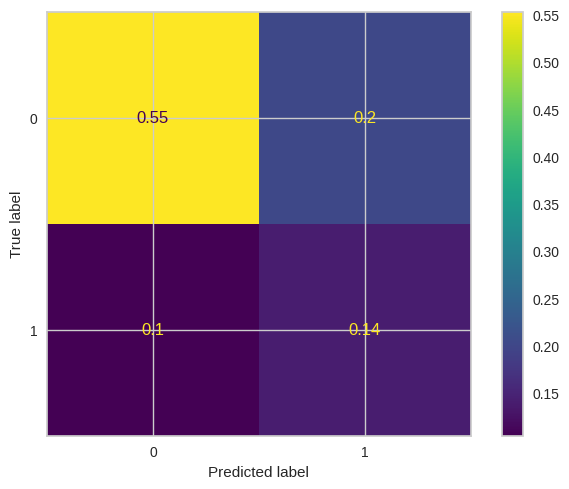

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_lr, normalize='all')).plot()

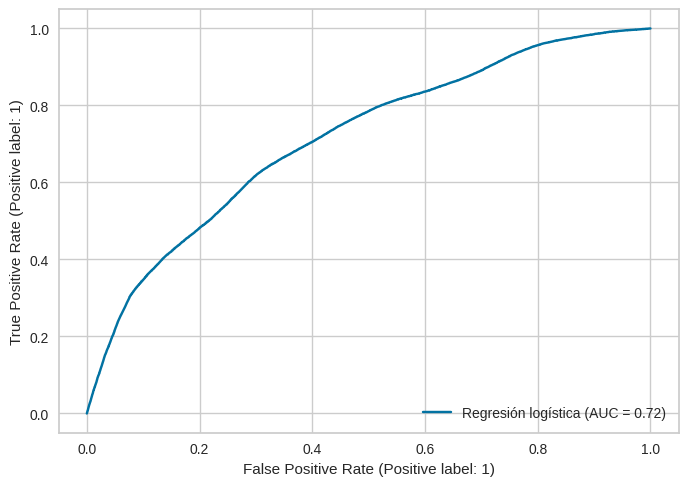

In [50]:
lr_roccurv = RocCurveDisplay.from_estimator(lr_search, X_test, y_test, name="Regresión logística")

#### 5.2. Random Forest

In [51]:
rf_model = Pipeline([
   ("preprocesamiento", preproc), 
   ("remuestreo", SMOTE()),
   ("modelo", RandomForestClassifier(class_weight="balanced", n_jobs=-1)),
])

**Optimización de hiperparámetros**

In [52]:
grid = [
    {
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__n_estimators': [100, 200, 400],   
    }
]

rf_search = GridSearchCV(rf_model, grid, scoring="f1_macro", cv=TimeSeriesSplit())

rf_search.fit(X_train, y_train)

pd.Series(rf_search.best_params_, name="valor").to_frame()

,valor
modelo__n_estimators,200
remuestreo,passthrough


In [ ]:
joblib.dump(rf_search.best_estimator_ , "rf_model.joblib")

##### 5.2.1. Evaluación

In [53]:
y_pred_rf = rf_search.predict(X_test)
print(classification_report(y_pred_rf, y_test))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84    119931
           1       0.61      0.51      0.56     49349

    accuracy                           0.76    169280
   macro avg       0.71      0.69      0.70    169280
weighted avg       0.75      0.76      0.76    169280



Se ve un incremento de aproximadamente un 10% en el f1-score con respecto al modelo completo usando el algoritmo de regresión logística

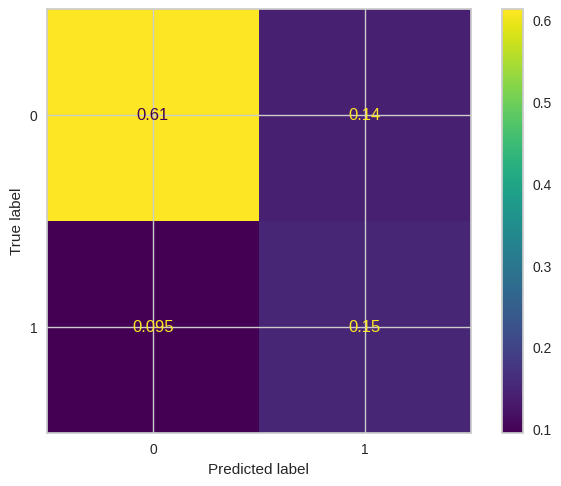

In [54]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf, normalize='all')).plot()

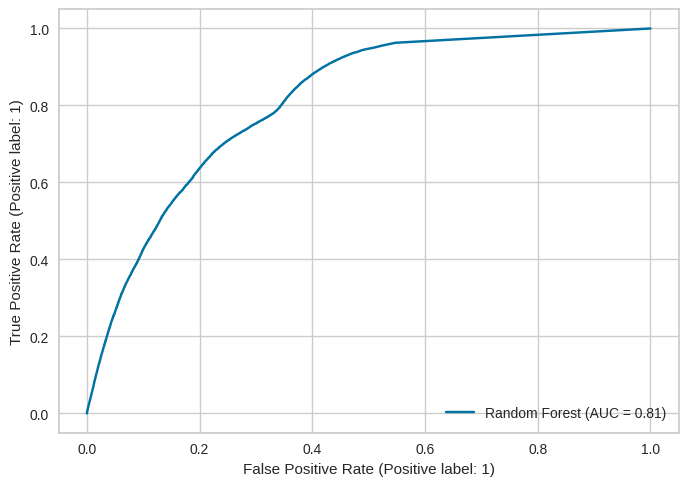

In [55]:
rf_roccurv = RocCurveDisplay.from_estimator(rf_search, X_test, y_test, name="Random Forest")

#### 5.3. XGBoost

In [56]:
xgb_model = Pipeline([
   ("preprocesamiento", preproc), 
   ("remuestreo", SMOTE()),
   ("modelo", XGBClassifier(n_jobs=-1)),
])

**Optimización de hiperparámetros**

In [57]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


grid = [
    {
        'remuestreo': ['passthrough', SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__n_estimators': [100, 200, 400], 
        'modelo__scale_pos_weight': [1, 2, 4], 
        'modelo__tree_method': ['hist', 'approx'], 
    }
]

xgb_search = GridSearchCV(xgb_model, grid, scoring="f1_macro", cv=TimeSeriesSplit())

xgb_search.fit(X_train, y_train)

pd.Series(xgb_search.best_params_, name="valor").to_frame()

,valor
modelo__n_estimators,100
modelo__scale_pos_weight,2
modelo__tree_method,hist
remuestreo,passthrough


In [ ]:
joblib.dump(xgb_search.best_estimator_ , "xgb_model.joblib")

##### 5.3.1. Evaluación

In [58]:
y_pred_xgb = xgb_search.predict(X_test)
print(classification_report(y_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85    109837
           1       0.78      0.54      0.64     59443

    accuracy                           0.78    169280
   macro avg       0.78      0.73      0.74    169280
weighted avg       0.78      0.78      0.77    169280



Se ve una mejora de 0.3 aproximadamente en el f1-score con respecto al modelo completo de regresión lineal, y una mejora de 0.4 con respecto al modelo base, es decir, una mejora de prácticamente el 100% con respecto al f1-score del modelo base.

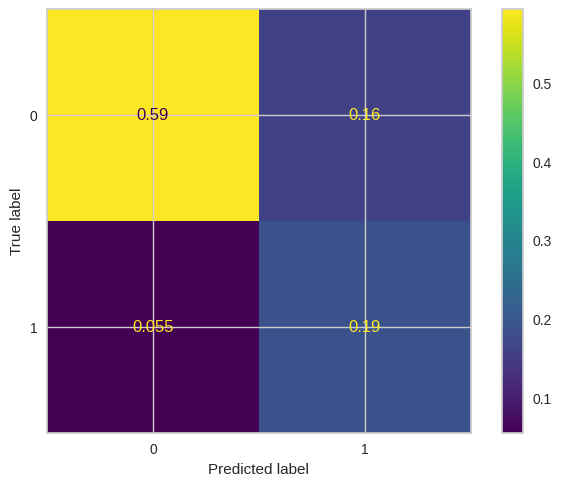

In [59]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_xgb, normalize='all')).plot()

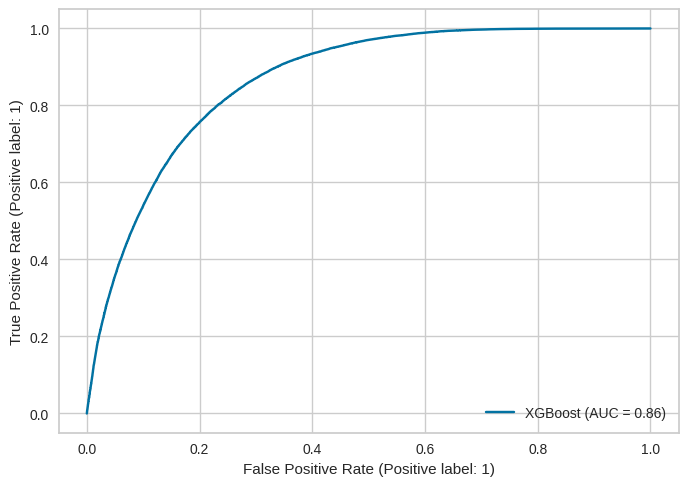

In [60]:
xgb_roccurv = RocCurveDisplay.from_estimator(xgb_search, X_test, y_test, name="XGBoost")

### 6. Comparación de modelos

#### 6.1. Área bajo la curva

Se compara el ROC de los tres modelos

In [61]:
sns.set_theme("paper", style="whitegrid", palette="muted")

Text(0.5, 1.0, 'Comparación de la curva ROC de los tres modelos')

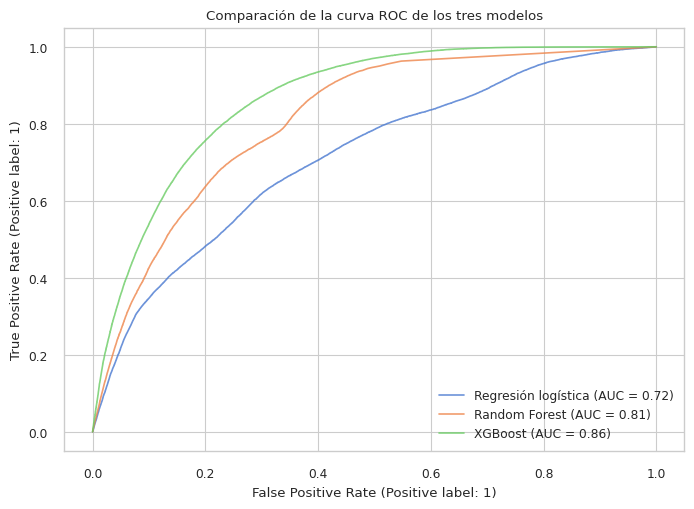

In [62]:
ax = plt.gca()

lr_roccurv.plot(ax=ax, alpha=0.8)
rf_roccurv.plot(ax=ax, alpha=0.8)
xgb_roccurv.plot(ax=ax, alpha=0.8)

plt.title("Comparación de la curva ROC de los tres modelos")

Se ve que el algoritmo XGBoost es el que tiene una mayor área bajo la curva, seguido de cerca por el random forest, y superando por un margen amplio a la regresión logística.

#### 6.2. F1-score, cobertura y precisión

Se generan gráficos para comparar el desempeño de los modelos en las métricas `f1_score`, `cobertura` y `precisión`

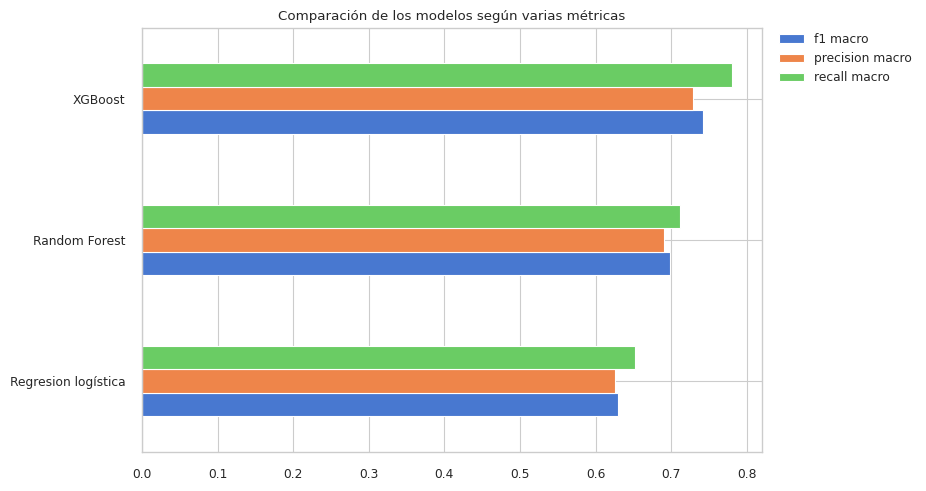

In [63]:
predicciones = {
    "Regresion logística": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
}

metricas = {
    "f1 macro": f1_score,
    "recall macro": recall_score,
    "precision macro": precision_score,
}

ax = pd.Series(
    {(model, metrica): metric(y_test, pred, average="macro") for model, pred in predicciones.items() for metrica, metric in metricas.items()}
).unstack().sort_values("f1 macro").plot.barh(title="Comparación de los modelos según varias métricas")

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

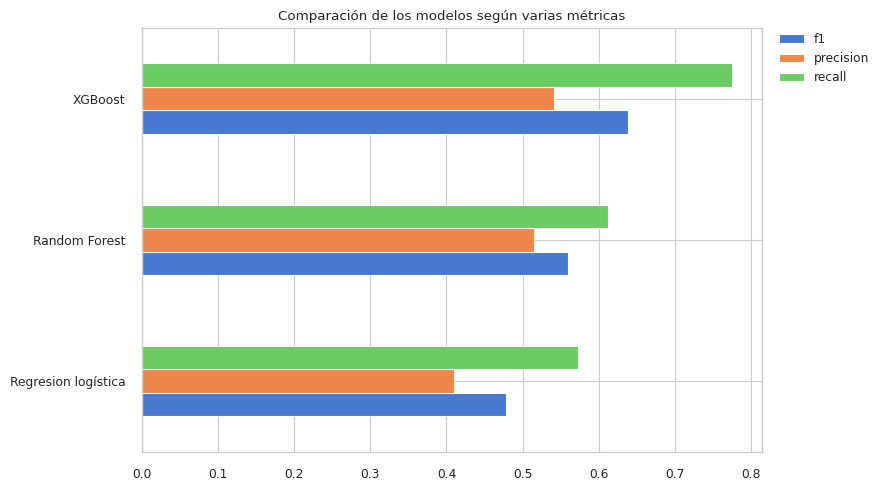

In [64]:
from sklearn.metrics import f1_score, recall_score, precision_score

predicciones = {
    "Regresion logística": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
}

metricas = {
    "f1": f1_score,
    "recall": recall_score,
    "precision": precision_score,
}

pd.Series(
    {(model, metrica): metric(y_test, pred) for model, pred in predicciones.items() for metrica, metric in metricas.items()}
).unstack().sort_values("f1").plot.barh(title="Comparación de los modelos según varias métricas")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Se observa el mismo patrón que en la comparación de área bajo la curva: el algoritmo XGBoost es el que tiene mejor desempeño en las tres métricas, seguido de random forest, y quedando de última la regresión logística

### 7. Importancia de las características

Se muestran las características que mayor peso tienen en el modelo

<Axes: >

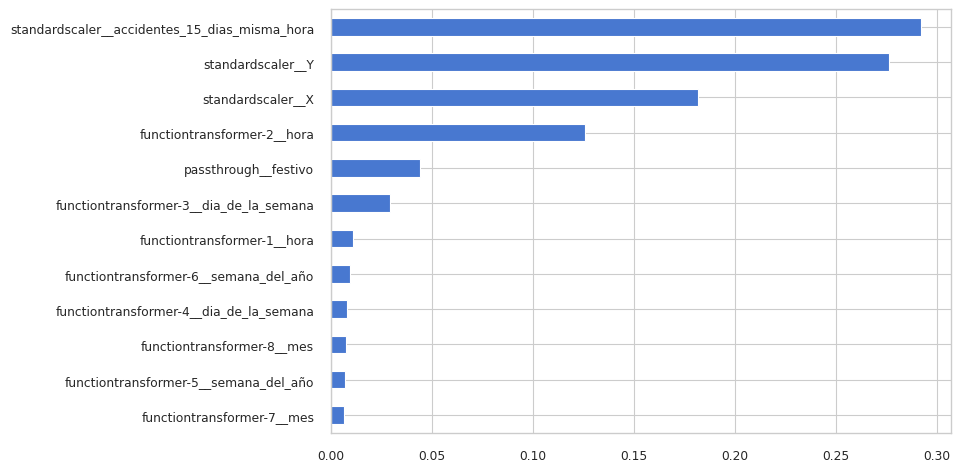

In [65]:
caracteristicas = pd.Series(
    xgb_search.best_estimator_[-1].feature_importances_,
    index=xgb_search.best_estimator_[:-1].get_feature_names_out()
).sort_values()

caracteristicas.plot.barh()

Juntamos las características que se han procesado de formas distintas (seno y coseno) y ajustamos los nombres

<Axes: title={'center': 'Características utilizadas según su importancia en el modelo'}>

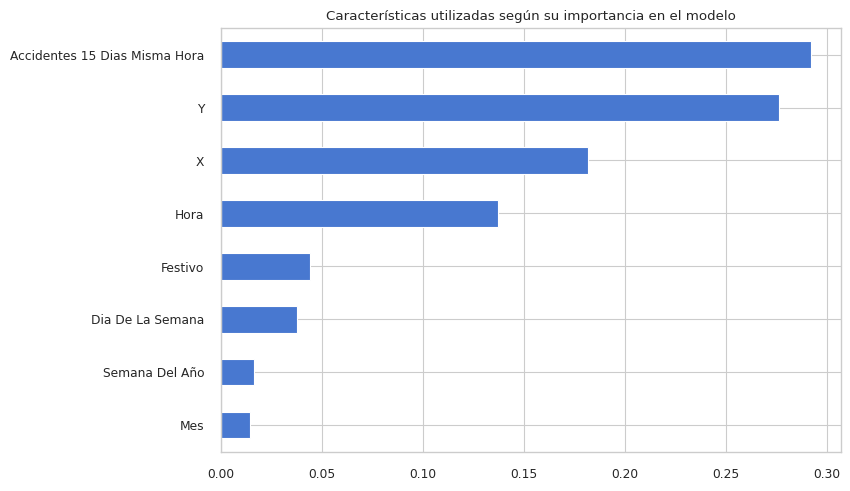

In [66]:
caracteristicas.groupby(
    caracteristicas.index.map(lambda x: x.split("__")[-1].replace("_", " ").title())
).sum().sort_values().plot.barh(title="Características utilizadas según su importancia en el modelo")

Se ve que la ocurrencia de accidentes en los últimos 15 dias en la misma franja horaria es la característica de mayor peso en el modelo, lo cual refleja un comportamiento cíclico en la ocurrencia de accidentes.

### 8. Separación de las clases de acuerdo a la probabilidad estimada

In [67]:
probas = xgb_search.predict_proba(X_test)[:,1]

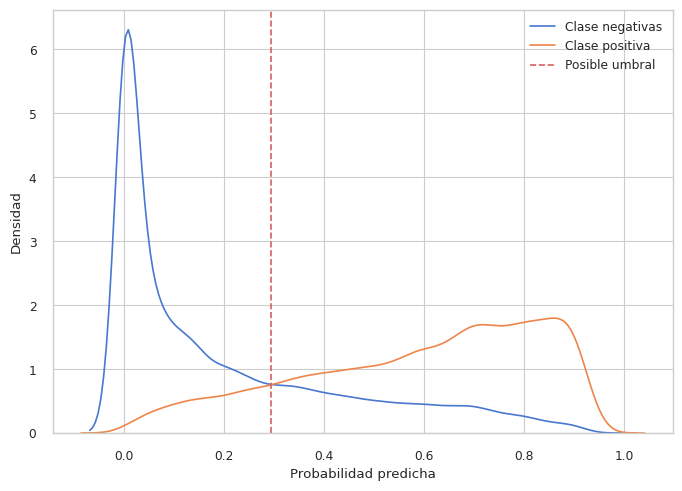

In [114]:
sns.kdeplot(probas[y_test==0], label="Clase negativas")
sns.kdeplot(probas[y_test==1], label="Clase positiva")

plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.axvline(x=.295, color="r", linestyle="--", label="Posible umbral")
plt.legend()
